In [2]:
! pip install rioxarray
! pip install xarray
! pip install catboost
! pip install geopandas
! pip install statsmodels

In [3]:
import geopandas as gpd
import rasterio
import rioxarray as rxr
import xarray as xr
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt

# Read in Model Ground Truth

In [4]:
bucket='sagemaker-us-east-1-565022919370/Input_ResponseVar_NOAA_reports_presence_100m'
data_key = 'NOAA_reports_presence_100m.shp'
data_location = 's3://{}/{}'.format(bucket, data_key)

presence = gpd.read_file(data_location)

bucket='sagemaker-us-east-1-565022919370/Input_ResponseVar_absence_points_100m'
data_key = 'absence_points_100m.shp'
data_location = 's3://{}/{}'.format(bucket, data_key)

absence = gpd.read_file(data_location)

combined_response = pd.concat([presence, absence], axis = 0)

In [5]:
combined_response

,flood,geometry
0,1.0,POINT (-177199.145 2764524.542)
1,1.0,POINT (773306.560 1815039.814)
2,1.0,POINT (1012673.548 2005202.046)
3,1.0,POINT (824897.556 1790830.726)
4,1.0,POINT (864981.557 1820794.672)
...,...,...
71429,0.0,POINT (-1822995.000 1266155.000)
71430,0.0,POINT (-1786595.000 1261855.000)
71431,0.0,POINT (-1815495.000 1259755.000)
71432,0.0,POINT (-1787895.000 1257355.000)


# Read in Paper Predictions

In [6]:
bucket='sagemaker-us-east-1-565022919370/Output_CONUS_FDP_100m'
data_key = 'CONUS_FDP_100m.tif'
data_location = 's3://{}/{}'.format(bucket, data_key)

predictions_src = rasterio.open(data_location)

# Read in Social Vulnerability Index

In [7]:
svi_src = rasterio.open('svi_2018_tract_overall_nad83_nopop.tif')

# Read in Temperature 

In [8]:
temperature_src = rasterio.open('temperature.tif')

# Get Social Vulnerability Index for Ground Truth

In [9]:
svi_src.crs

CRS.from_epsg(4269)

In [10]:
%%time
combined_response['geometry'] = combined_response.geometry.to_crs('4269')

combined_response.index = range(len(combined_response))
coords = [(x,y) for x, y in zip(combined_response.geometry.x, combined_response.geometry.y)]

# Sample the raster at every point location and store values in DataFrame
combined_response['social_vulnerability_index'] = [x for x in svi_src.sample(coords)]
combined_response['social_vulnerability_index'] = combined_response.apply(lambda x: x['social_vulnerability_index'][0], axis=1)

CPU times: user 7.93 s, sys: 81.4 ms, total: 8.01 s
Wall time: 8.01 s


In [11]:
# some min values are negative which doesn't make sense
combined_response.social_vulnerability_index.describe()

count    1.428680e+05
mean             -inf
std               inf
min     -3.400000e+38
25%      2.138000e-01
50%      4.427000e-01
75%      6.560000e-01
max      1.000000e+00
Name: social_vulnerability_index, dtype: float64

In [12]:
# these look like errors / places that couldn't match to real values 
# replacing them with the mean 
combined_response.social_vulnerability_index[combined_response.social_vulnerability_index < 0].describe()

count    1.249400e+04
mean             -inf
std      0.000000e+00
min     -3.400000e+38
25%     -3.400000e+38
50%     -3.400000e+38
75%     -3.400000e+38
max     -3.400000e+38
Name: social_vulnerability_index, dtype: float64

In [13]:
combined_response['social_vulnerability_index']  = np.where(combined_response['social_vulnerability_index'] < 0, None, combined_response['social_vulnerability_index'])

In [14]:
combined_response['social_vulnerability_index']  = combined_response['social_vulnerability_index'].fillna(combined_response['social_vulnerability_index'].mean(skipna=True))

## Get SVI Components for Ground Truth

In [15]:
socioeconomic_src = rasterio.open('svi_2018_tract_socioeconomic_nad83_nopop.tif')
minority_src = rasterio.open('svi_2018_tract_minority_nad83_nopop.tif')
housing_src = rasterio.open('svi_2018_tract_housing_nad83_nopop.tif')
household_src = rasterio.open('svi_2018_tract_household_nad83_nopop.tif')

In [16]:
socioeconomic_src.crs

CRS.from_epsg(4269)

In [45]:
%%time
combined_response['geometry'] = combined_response.geometry.to_crs('4269')

combined_response.index = range(len(combined_response))
coords = [(x,y) for x, y in zip(combined_response.geometry.x, combined_response.geometry.y)]

# socioeconomic
combined_response['socioeconomic_index'] = [x for x in socioeconomic_src.sample(coords)]
combined_response['socioeconomic_index'] = combined_response.apply(lambda x: x['socioeconomic_index'][0], axis=1)

# minority
combined_response['minority_index'] = [x for x in minority_src.sample(coords)]
combined_response['minority_index'] = combined_response.apply(lambda x: x['minority_index'][0], axis=1)

# housing
combined_response['housing_index'] = [x for x in housing_src.sample(coords)]
combined_response['housing_index'] = combined_response.apply(lambda x: x['housing_index'][0], axis=1)

# household
combined_response['household_index'] = [x for x in household_src.sample(coords)]
combined_response['household_index'] = combined_response.apply(lambda x: x['household_index'][0], axis=1)

CPU times: user 30.7 s, sys: 203 ms, total: 30.9 s
Wall time: 30.9 s


In [46]:
combined_response['socioeconomic_index']  = np.where(combined_response['socioeconomic_index'] < 0, None, combined_response['socioeconomic_index'])
combined_response['minority_index']  = np.where(combined_response['minority_index'] < 0, None, combined_response['minority_index'])
combined_response['housing_index']  = np.where(combined_response['housing_index'] < 0, None, combined_response['housing_index'])
combined_response['household_index']  = np.where(combined_response['household_index'] < 0, None, combined_response['household_index'])

combined_response['socioeconomic_index']  = combined_response['socioeconomic_index'].fillna(combined_response['socioeconomic_index'].mean(skipna=True))
combined_response['minority_index']  = combined_response['minority_index'].fillna(combined_response['minority_index'].mean(skipna=True))
combined_response['housing_index']  = combined_response['housing_index'].fillna(combined_response['housing_index'].mean(skipna=True))
combined_response['household_index']  = combined_response['household_index'].fillna(combined_response['household_index'].mean(skipna=True))

# Get Model Predictions for Ground Truth

In [47]:
predictions_src.crs

CRS.from_epsg(5070)

In [20]:
%%time 

combined_response['geometry'] = combined_response.geometry.to_crs('5070')

coords = [(x,y) for x, y in zip(combined_response.geometry.x, combined_response.geometry.y)]

# Sample the raster at every point location and store values in DataFrame
combined_response['original_model_prediction'] = [x for x in predictions_src.sample(coords)]
combined_response['original_model_prediction'] = combined_response.apply(lambda x: x['original_model_prediction'][0], axis=1)

CPU times: user 1min 18s, sys: 10.3 s, total: 1min 29s
Wall time: 23min 2s


In [21]:
# some min values are negative which doesn't make sense, doing the same as above
combined_response.original_model_prediction.describe()

count    1.428680e+05
mean             -inf
std               inf
min     -3.400000e+38
25%      3.231171e-01
50%      4.754409e-01
75%      6.450768e-01
max      1.000000e+00
Name: original_model_prediction, dtype: float64

In [22]:
combined_response['original_model_prediction_backup'] = combined_response['original_model_prediction']
combined_response['original_model_prediction']  = np.where(combined_response['original_model_prediction'] < 0, None, combined_response['original_model_prediction'])
combined_response['original_model_prediction']  = combined_response['original_model_prediction'].fillna(combined_response['original_model_prediction'].mean(skipna=True))

# Get Temperature for Ground Truth

In [23]:
temperature_src.crs

CRS.from_epsg(3857)

In [24]:
%%time
combined_response['geometry'] = combined_response.geometry.to_crs('3857')

coords = [(x,y) for x, y in zip(combined_response.geometry.x, combined_response.geometry.y)]

# Sample the raster at every point location and store values in DataFrame
combined_response['temperature_index'] = [x for x in temperature_src.sample(coords)]
combined_response['temperature_index'] = combined_response.apply(lambda x: x['temperature_index'][0], axis=1)

CPU times: user 8.21 s, sys: 69.7 ms, total: 8.28 s
Wall time: 8.87 s


# Get Emissions for Ground Truth

In [25]:
emissions_src = rasterio.open('onroad_2017.tif')

emissions_src.crs

CRS.from_epsg(4269)

In [26]:
%%time

with rasterio.open('onroad_2017.tif', 'r+') as emissions_src:
    # emissions_src.crs = CRS.from_epsg(4269)
    combined_response['geometry'] = combined_response.geometry.to_crs('4269')

    coords = [(x,y) for x, y in zip(combined_response.geometry.x, combined_response.geometry.y)]

    # Sample the raster at every point location and store values in DataFrame
    combined_response['emissions_index'] = [x for x in emissions_src.sample(coords)]
    combined_response['emissions_index'] = combined_response.apply(lambda x: x['emissions_index'][0], axis=1)

CPU times: user 6.73 s, sys: 38.8 ms, total: 6.77 s
Wall time: 6.78 s


In [27]:
combined_response['emissions_index'].sample(190)

10792     11823.216409
102041    11823.216409
117245    11823.216409
37250     11823.216409
120434    11823.216409
              ...     
107173    11823.216409
47261     11823.216409
76533     11823.216409
75652     11823.216409
77975     11823.216409
Name: emissions_index, Length: 190, dtype: float64

# Build Model

## Original AUC

In [28]:
# split into train/test
train, test = train_test_split(combined_response, test_size = .15, random_state = 10)

X_train = train[[
    'original_model_prediction', 
                                    # 'social_vulnerability_index', 
                       'socioeconomic_index', 
                       'minority_index', 
                       'housing_index',
                       'household_index', 
                                   'temperature_index'
                      ]]
y_train = train[['flood']].astype('int')

X_test = test[['original_model_prediction', 
                                    # 'social_vulnerability_index', 
                       'socioeconomic_index', 
                       'minority_index', 
                       'housing_index',
                       'household_index', 
                                   'temperature_index'
                      ]]
y_test = test[['flood']].astype('int')

In [29]:
auc = metrics.roc_auc_score(y_test, X_test['original_model_prediction'])
print(auc)

0.8893568350939733


In [30]:
combined_response.groupby('flood')[['original_model_prediction', 
                                    'social_vulnerability_index', 'socioeconomic_index', 'minority_index', 'housing_index', 'household_index', 
                                   'temperature_index']].mean()

,original_model_prediction,social_vulnerability_index,socioeconomic_index,minority_index,housing_index,household_index,temperature_index
flood,,,,,,,
0.0,0.346030,0.471740,0.504825,0.312548,0.480693,0.585208,12.721767
1.0,0.657217,0.490364,0.514732,0.321745,0.505641,0.594906,13.275267


In [31]:
X = combined_response[['original_model_prediction', 
                                    # 'social_vulnerability_index', 
                       'socioeconomic_index', 
                       'minority_index', 
                       'housing_index',
                       'household_index', 
                                   'temperature_index'
                      ]]#.sample(100)
y = combined_response[['flood']].astype('int')#.sample(100)

In [32]:
X.corr()

,original_model_prediction,socioeconomic_index,minority_index,housing_index,household_index,temperature_index
original_model_prediction,1.000000,0.034337,0.033489,0.047639,0.023954,0.134336
socioeconomic_index,0.034337,1.000000,0.235928,0.490928,0.584945,0.301220
minority_index,0.033489,0.235928,1.000000,0.256742,-0.033691,0.382548
housing_index,0.047639,0.490928,0.256742,1.000000,0.329936,0.080101
household_index,0.023954,0.584945,-0.033691,0.329936,1.000000,0.146089
temperature_index,0.134336,0.301220,0.382548,0.080101,0.146089,1.000000


## Logistic Regression

Significant values, but not that good.

In [33]:
logreg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.492306
         Iterations 6


In [34]:
logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  flood   No. Observations:               121437
Model:                          Logit   Df Residuals:                   121431
Method:                           MLE   Df Model:                            5
Date:                Wed, 04 Oct 2023   Pseudo R-squ.:                  0.2898
Time:                        03:14:04   Log-Likelihood:                -59784.
converged:                       True   LL-Null:                       -84174.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
original_model_prediction     6.9122      0.042    165.071      0.000       6.830       6.994
socioeconomic_index           0.2838      0.041      6.885      0.000       0.203       0.365
minority_index               -0.1175      0.034     -3.435      0.001      -0.184      -0.050
housing_index                -0.8624      0.032    -26.544      0.000      -0.926      -0.799
household_index              -1.6043      0.036    -45.090      0.000      -1.674      -1.535
temperature_index            -0.1465      0.002    -83.890      0.000      -0.150      -0.143
=============================================================================================
"""

In [35]:
predicted_proba = logreg.predict(X_test)

auc = metrics.roc_auc_score(y_test, predicted_proba)
print(auc)

0.8400007009162983


In [36]:
predicted_proba.describe()

count    21431.000000
mean         0.536497
std          0.292745
min          0.009271
25%          0.275784
50%          0.536666
75%          0.802933
max          0.996000
dtype: float64

## Cat Boost

In [37]:
clf = CatBoostClassifier()

In [39]:
%%time
clf.fit(X_train,y_train)

Learning rate set to 0.079975
0:	learn: 0.6430689	total: 55.1ms	remaining: 55.1s
1:	learn: 0.6050515	total: 62.6ms	remaining: 31.2s
2:	learn: 0.5698723	total: 69.2ms	remaining: 23s
3:	learn: 0.5417505	total: 75.9ms	remaining: 18.9s
4:	learn: 0.5208776	total: 82.4ms	remaining: 16.4s
5:	learn: 0.4980216	total: 89ms	remaining: 14.7s
6:	learn: 0.4855138	total: 95.9ms	remaining: 13.6s
7:	learn: 0.4746832	total: 103ms	remaining: 12.7s
8:	learn: 0.4654018	total: 110ms	remaining: 12.1s
9:	learn: 0.4588638	total: 117ms	remaining: 11.5s
10:	learn: 0.4528814	total: 124ms	remaining: 11.1s
11:	learn: 0.4462351	total: 131ms	remaining: 10.8s
12:	learn: 0.4415262	total: 138ms	remaining: 10.5s
13:	learn: 0.4362530	total: 145ms	remaining: 10.2s
14:	learn: 0.4336424	total: 152ms	remaining: 9.96s
15:	learn: 0.4310923	total: 158ms	remaining: 9.71s
16:	learn: 0.4294265	total: 164ms	remaining: 9.5s
17:	learn: 0.4266213	total: 171ms	remaining: 9.35s
18:	learn: 0.4250347	total: 179ms	remaining: 9.22s
19:	learn

In [40]:
predicted_proba = clf.predict_proba(X_test)

In [41]:
prob_flood = pd.DataFrame(predicted_proba)[1]

In [42]:
auc = metrics.roc_auc_score(y_test, prob_flood)
print(auc)

0.8935579173198855


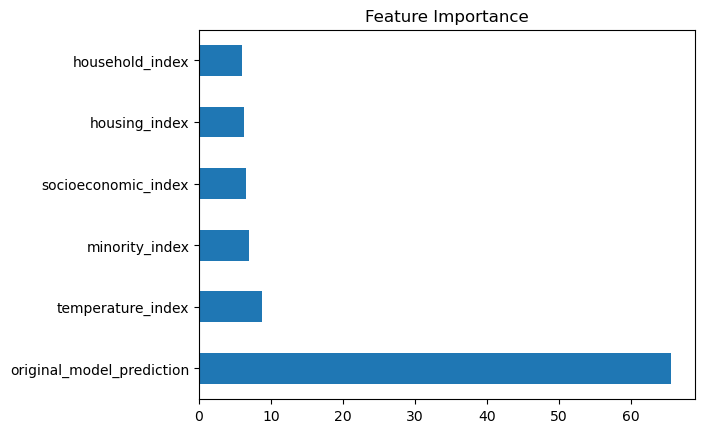

In [44]:
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [78]:
!jupyter nbconvert Model_Enhancement.ipynb --to python

[NbConvertApp] Converting notebook Model_Enhancement.ipynb to python
[NbConvertApp] Writing 10969 bytes to Model_Enhancement.py
